In [1]:
#boiler
import IPython
from IPython.display import IFrame, Image, display, YouTubeVideo
import pandas as pd
import numpy as np
#more boilerplat dawg
import matplotlib.pylab as plt
import seaborn as sns  # Makes for nicer plots
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4
%matplotlib inline

import pysal as ps
import pysal.spatial_dynamics.interaction as interaction
from matplotlib.patches import Ellipse, Circle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import interact, interactive, fixed

from shapely.geometry import Point
import geopandas

# National League Regular Season Home Runs

*I'm not exactly sure why iframes try to open in the window- beware of those*

#### I kind of dislike living at home...

As a rule, I'm not a huge fan of sports metaphors, especially from baseball. But it is the post-season and I really have nothing better to do...

Here's a list of what I want to do with this Lab:

- Tidy some Home Run data
- Visualize this Home Run data
- It appears as though two CO and MIL sluggers are tied in the NL
- It might be interesting to visualize how many NL leaders are from each team
- It might be interesting to view HR Distance/velocity off the bat
- It might be interesting even more to figure out the x,y,z of the HR path through calculating the angle off the bat/distance. The z value is from the apex or height of the ball. This kind of depends on the data I can find and how long I'm willing to sift through it all.
- Initial data comes from [ESPN](http://www.espn.com/mlb/homeruns/_/league/8/type/2)

- Columns are as follows:

 1. **RK** Stands for rank of player. There are a few gaps for ties which will be interesting to clean.
 2. **PLAYER** Really self-explanatory. The page actually has links to each player which might be included.
 3. **TEAM** I might add location data to make this more spatial. Quick aside: maybe NOAA and atmospheric pressure for each stadium?
 4. **HR** Human Resources OR Home Runs
 5. **PROJ** Projected Home Runs. Since the regular season is over, it would be wise to remove this column/variable.
 6. **APEX** The highest average point of home run in feet. I should really add a column and convert this unit to a real science distance (meters).
 7. **DIST** Distance of ball's flight.
 8. **SPD** Is the speed of the ball from the bat in miles per hour.
 9. **DUR** How long the ball lasted in the air in seconds.
 10. **PARKS** This is the number of parks the slam would be a Home Run. I wonder how ESPN calculates this statistic since the mean distance from home plate to the fence varies not only in each park but also at the angle from home plate to the fence. The only real way to do this would be to take the angle of the ball exiting the park and compare it to each park's distance from the fence at that particular angle.
 11. **ND** No doubt AKA the number of really deep blasts.
 12. **JE** Just enough or barely clearing the fence. These sometimes are robbed.
 13. **W % DELTA** Difference of win percentage before and after the HR. AKA how important was the HR in the team's success?
 
We have the z value. We have the distance. Now if only there were some sort of formula to calculate x,y coordinates... or better yet a spreadsheet with all of that information already compiled.

This looks promising: [Home Run Tracking](http://www.hittrackeronline.com/index.php)

In [7]:
data = "http://www.espn.com/mlb/homeruns/_/league/8/type/2"
url = "http://www.espn.com/mlb/player/_/id/31261/nolan-arenado"
#IFrame(data, width=700, height=350)
#IFrame(url, width=700, height=350)

## PARKS Update

After perusing ESPN's hittrackeronline site, it looks like they have paper versions available for each HR's flight path. I'm gonna go out on a limb and say that they also have a digitized version somewhere which would make getting the x,y,z coordinates easier. If not, there's also a way to calculate X,Y information from just the distance/angle of the hit using python... right?

An example of the paper version even looks like a graph:

![Ballpark Graph Image](werth.jpg "werth")

There is [Statcast](http://m.mlb.com/statcast/leaderboard#exit-velo,r,2016) which gives exit velocity, distance, batted ball direction (-49-50 degrees) launch angle, etc. Through some maths, this would give me the x,y,z, however some of these attribute fields are not available in the downloadable .csv file. Specifically, the angle from the batter's hit is not included in the downloaded spreadsheet which is essential to calculating the true x,y location (along with distance).

I assume more complete data exists somewhere in the .xml/json files which are located in [this here database](http://gd2.mlb.com/components/game/mlb/).

Back to tidying and visualizing what data we do have, which for now will boil down to not-real spatial data (for now).

In [8]:
data = pd.read_html(data,header=1)
data[0].head()

,RK,PLAYER,TEAM,HR,PROJ,APEX,DIST,SPD,DUR,PARKS,ND,JE,W % DELTA
0,1.0,Nolan Arenado,COL,41.0,41.0,89.71,407.81,105.10,4.93,27.46,11.0,9.0,12.9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Chris Carter,MIL,41.0,41.0,93.43,410.88,105.49,5.10,24.88,4.0,10.0,12.4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,Kris Bryant,CHC,39.0,39.0,97.15,405.10,104.49,5.16,25.23,11.0,8.0,11.4


In [9]:
data[0].drop(['RK','PROJ'], axis=1, inplace=True)
data[0].head()

,PLAYER,TEAM,HR,APEX,DIST,SPD,DUR,PARKS,ND,JE,W % DELTA
0,Nolan Arenado,COL,41.0,89.71,407.81,105.10,4.93,27.46,11.0,9.0,12.9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chris Carter,MIL,41.0,93.43,410.88,105.49,5.10,24.88,4.0,10.0,12.4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kris Bryant,CHC,39.0,97.15,405.10,104.49,5.16,25.23,11.0,8.0,11.4


In [10]:
df = data[0].iloc[::2, :]
df.head()

,PLAYER,TEAM,HR,APEX,DIST,SPD,DUR,PARKS,ND,JE,W % DELTA
0,Nolan Arenado,COL,41.0,89.71,407.81,105.10,4.93,27.46,11.0,9.0,12.9
2,Chris Carter,MIL,41.0,93.43,410.88,105.49,5.10,24.88,4.0,10.0,12.4
4,Kris Bryant,CHC,39.0,97.15,405.10,104.49,5.16,25.23,11.0,8.0,11.4
6,Matt Kemp,ATL,34.0,91.91,407.88,104.55,5.12,26.44,6.0,7.0,12.0
8,Adam Duvall,CIN,33.0,87.09,399.67,104.61,4.83,23.85,9.0,12.0,12.8


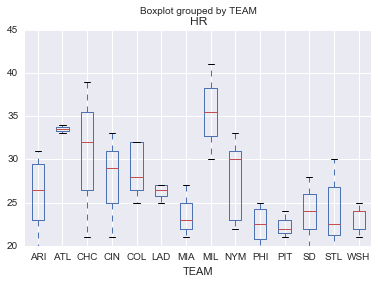

In [11]:
df.boxplot(column = 'HR', by = 'TEAM')

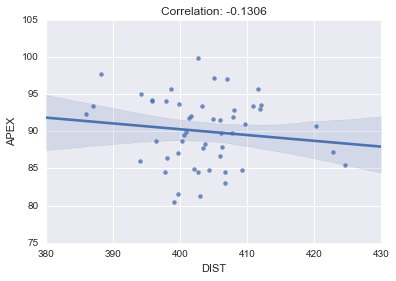

In [12]:
corr = df.DIST.corr(df.APEX)
ax = sns.regplot(x="DIST", y="APEX",
                 data=df).set_title("Correlation: {:.4}".format(corr))

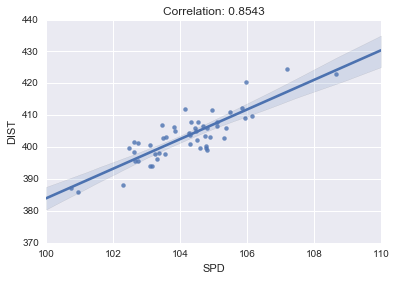

In [13]:
corr = df.SPD.corr(df.DIST)
ax = sns.regplot(x="SPD", y="DIST",
                 data=df).set_title("Correlation: {:.4}".format(corr))

The boxplot gives a nice visual of the average number of HRs hit by each team based on the top 50 HR hitters in the NL. I think the top spread of CO got altered because the max spread should be above the MIL max. A few teams have more observations of HR hitters in the top 50. This doesn't really prove anything but looks cool.


Distance and height have a negative correlation when plotted in a simple correlation graph measuring the slope of the regression line through the two variables. This makes sense since ultra high balls usually don't go anywhere. According to basic physics, a ball leaving the bat at 45 degrees would be most optimal in a vacuum of space with no external variables. Since this type of vacuum doesn't exist, it would make sense to see how exit velocity and distance correlates, especially with added variables like atmospheric pressure/weather/spatial location. But that's a question for another dataset.

A simple correlation between the speed of the ball leaving the bat (SPD) and the distance (DIST) the ball traveled has a value of .85. Neat! 

Let's take this a step further and try to compute a knox test to find out the space-time relationship between SPD, DIST, and DUR (time spent in the air). The speed and distance will substitute for the spatial component and duration in the air will act as the time component.

To test this using pysal, we need to convert the dataframe to a shapefile, which is easy to do with shapely and geopandas.

In [14]:
df['geometry'] = df.apply(lambda x: Point((float(x.DIST), float(x.SPD))), axis=1)
df = geopandas.GeoDataFrame(df, geometry='geometry')
df.to_file('hr.shp', driver='ESRI Shapefile')

/Users/davidleifer/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
path = "hr.shp"
burkitt = ps.pdio.read_files(path)
events = interaction.SpaceTimeEvents(path,'DUR')

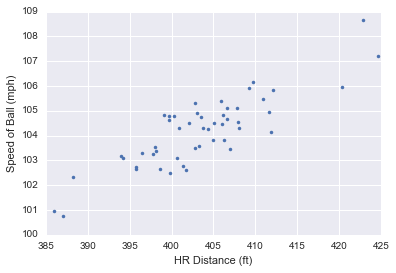

In [16]:
ax = plt.figure(figsize=(6, 4)).gca()
ax.plot(events.space[:, 0], events.space[:, 1], ".")
ax.set_xlabel("HR Distance (ft)")
ax.set_ylabel("Speed of Ball (mph)")
plt.show()

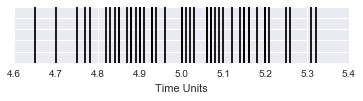

In [17]:
ax = plt.figure(figsize=(6, 1)).gca()
ax.vlines(events.t[:, 0], 0, 1)
ax.set_xlabel("Time Units")
plt.tick_params(axis='y', which='both', labelleft='off') 
plt.show()

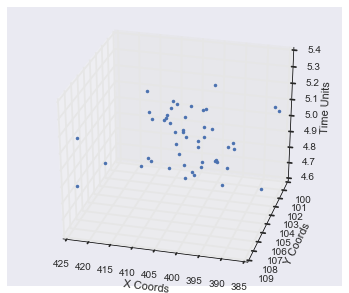

In [18]:
@interact(angle=(0, 240, 5))  # That's all it takes to make it interactive :)
def make_plot(angle):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)  # Use 'angle' parameter
    ax.set_ylabel("Speed of Ball (mph)")
    ax.set_xlabel("HR Distance (ft)")
    ax.set_zlabel("Time of Ball in the Air (sec)")
    ax.plot(events.space[:,0], events.space[:,1], events.t[:,0], ".")
    plt.show()

In [26]:
result = interaction.knox(events.space, events.t, delta=1, tau=.25, permutations=99)
result

{'pvalue': array([ 0.11]), 'stat': 31}

Now we have real data living in space-time, just not on this planet. Let's run some more stats from the lecture 4 homework.

## Modified Knox Test
Just because it was close(ish) in distance doesn't mean it was close(ish) in time. The Modified Knox Test kind of takes care of that.

$$T = \frac{1}{2}(\Sigma^n_{i=1} \Sigma^n_{j=1} f_{i j} g_{i j} - \frac{1}{n-1} \Sigma^n_{k=1} \Sigma^n_{l=1} \Sigma^n_{j=1} f_{kj} g_{lj})$$

Where $n$ = number of events, $f$ = adjacency in space, $g$ = adjacency in time (calculated in a manner equivalent to $a^{s}$ and $a^{t}$ above in the Knox test). The first part of this statistic is equivalent to the original Knox test, while the second part is the expected value under spatio-temporal randomness.

In [27]:
result = interaction.modified_knox(events.space, events.t, delta=1, tau=.25, permutations=99)
result

{'pvalue': 0.35999999999999999, 'stat': 1.6428571428571459}

I've used event counts closer than 1 unit in space and .25 units in time with 99 permutations.
## Mantel Test
The Mantel test *keeps* distance information discarded by the Knox tests. *Unstandardized* Mantel stat is calculated by summing the product of spatial and temporal distances between pairs.
## Unstandardized Mantel Test
$$ Z = \Sigma^n_i \Sigma^n_j (d^s_{i j} + c)^p(d^t_{i j} + c)^p $$
Where, again, $d^{s}$ and $d^{t}$ denote distance in space and time. The constant, $c$, and the power, $p$, usually default to 0 and 1 (binary?).
## Standardized Mantel Test
$$ r = \frac{1}{n^2 - n - 1} \Sigma^n_i \Sigma^n_j \Bigg[\frac{d^s_{ij} - \bar{d^s}}{\sigma_{d^s}}\Bigg] \Bigg[\frac{d^t_{ij} - \bar{d^t}}{\sigma_{d^t}}\Bigg] $$

Where $\bar{d^{s}}$ refers to the average distance in space, and $\bar{d^{t}}$ the average distance in time. For notational convenience $\sigma_{d^{t}}$ and $\sigma_{d^{t}}$ refer to the sample (not population) standard deviations, for distance in space and time, respectively.

In [28]:
result = interaction.mantel(events.space, events.t, permutations=99, scon=0.0, spow=1.0, tcon=0.0, tpow=1.0)
result

/Users/davidleifer/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)


{'pvalue': 0.70999999999999996, 'stat': -0.036547539535649536}

This type of stat is a Pearson correlation coefficient. Extreme values could distort the relationship and large samples are required to produce an accurate estimate. Correlations tend to be small since it compares all pairs of observations.

## Jacquez Test

This is a fix if we don't know what distances to use and instead substitutes a nearest neighbor distance approach. Maths:

$$a^t_{ijk} =
\left\{
    \begin{array}{ll}
        1,  & \mbox{if } event j is k nearest neighbor of event i in space \\
        {0,} & \mbox{otherwise }
    \end{array}
\right.$$

(lolz @ ijk)
Where $n$ = number of cases; $a^{s}$ = adjacency in space; $a^{t}$ = adjacency in time.

In [38]:
result = interaction.jacquez(events.space, events.t ,k=3,permutations=99)
result

{'pvalue': 0.23000000000000001, 'stat': 13}

Since there is not enough evidence from these tests (p-value was above .05), we fail to reject the null hypothesis of space-time interaction.

# Finding Actual x,y,z Data

This isn't real x,y,z data of the ball's flight path like I initially set out to find. Rather, it's more of a spatial cluster examination between speed, distance, and duration of the ball's flight when these attributes are plotted.

The next step for this would be to sift through the .xml/json data ([MLB Database](http://gd2.mlb.com/components/game/mlb/)) to get the batted ball distance, exit velocity, distance, etc. and combine this information with NOAA data ([NOAA](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/quality-controlled-local-climatological-data-qclcd)) and atmospheric pressure to construct a machine learning algorithm to predict the location of a hit.

And someone actually does that here: [Hit Prediction](http://www.hardballtimes.com/using-statcast-data-to-predict-hits/). From this they used launch angle, batted ball speed, overall distance of the hit, and the location in x,y to feed a [modified random forest algorithm](https://www.youtube.com/watch?v=loNcrMjYh64), which is basically a collection of decorrelated decision trees. The Hardball website (most likely named for [this baseball movie starring Neo](https://www.youtube.com/watch?v=mb7Gupu3M2Y)) also looked at the impact of atmospheric conditions on flight trajectory: [Going Deep](http://www.hardballtimes.com/going-deep-on-goin-deep/). This article looks at the spatial component of ballparks in how weather and pressure influence the ball's flight path. I will probably delve deeper into this portion since Denver is such a statistical anomaly.

Colorado apparently is fun to play in.
![Ballpark](coorsSUN.png "werth")

# UPDATE
## Found actual xyz data

After some more digging, I found a microsoft database containing the x and y data from [this site](http://www.banishedtothepen.com/updated-mlb-statcast-data-july-2015/). It only contains hits from April to the end of June, 2015, but this is over 40,000 rows of information and will be well served to build a machine learning model on (should I decide to invest that much time). I plan on borrowing a large amount of code from [DanDoesData](https://www.youtube.com/playlist?list=PLFxrZqbLojdJIMff4WzpXpk1G2pEa3jAb)'s self-driving car python model as well as [Bill Petti](https://github.com/BillPetti/Statcast-Modeling)'s hit prediction R model if I do get around to the machine modeling. NOAA information will also be included as stated previously.

In [2]:
data = pd.read_csv("BASEBALL_SAVANT_BATTER.csv",header=0)

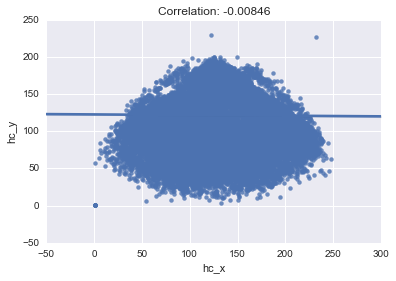

In [5]:
corr = data.hc_x.corr(data.hc_y)
ax = sns.regplot(x="hc_x", y="hc_y",
                 data=data).set_title("Correlation: {:.4}".format(corr))

In [10]:
#data['tfs_zulu'] = data['tfs_zulu'].str.replace('2015-' , '').str.replace('Z' , '').str.replace('T' , '').str.replace(':' , '').str.replace('-' , '')
#data['tfs_zulu'] = data['tfs_zulu'].astype('float64') 
data['tfs_zulu'].head()

0    527023024.0
1    612003731.0
2    515231717.0
3    525175637.0
4    621173209.0
Name: tfs_zulu, dtype: float64

In [11]:
data['geometry'] = data.apply(lambda x: Point((float(x.hc_x), float(x.hc_y))), axis=1)
df = geopandas.GeoDataFrame(data, geometry='geometry')
df.to_file('burkitt.shp', driver='ESRI Shapefile')

In [12]:
print('(quietly move .shp to examples pysal site-package)')
path = "burkitt.shp"
batting = ps.pdio.read_files(path)
events = interaction.SpaceTimeEvents(path,'tfs_zulu')

(quietly move .shp to examples pysal site-package)


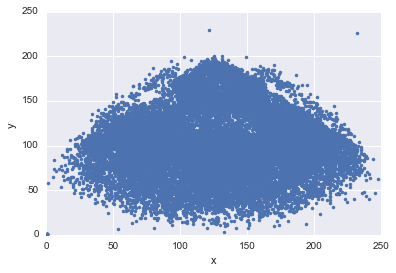

In [13]:
ax = plt.figure(figsize=(6, 4)).gca()
ax.plot(events.space[:, 0], events.space[:, 1], ".")
ax.set_xlabel("x")
ax.set_ylabel("y ")
plt.show()

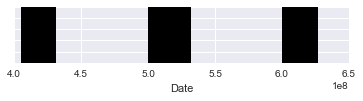

In [14]:
ax = plt.figure(figsize=(6, 1)).gca()
ax.vlines(events.t[:, 0], 0, 1)
ax.set_xlabel("Date")
plt.tick_params(axis='y', which='both', labelleft='off') 
plt.show()

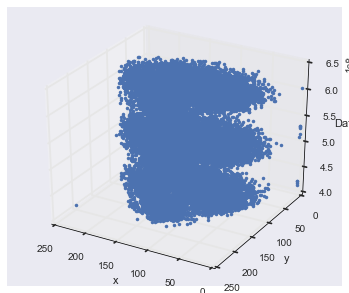

In [15]:
@interact(angle=(0, 240, 5))  # That's all it takes to make it interactive :)
def make_plot(angle):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)  # Use 'angle' parameter
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_zlabel("Date")
    ax.plot(events.space[:,0], events.space[:,1], events.t[:,0], ".")
    plt.show()

In [33]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('user', 'api-key') # gotta make ur own

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 400).transpose()



In [34]:
trace1 = go.Scatter3d(
    x=data['hc_x'],
    y=data['hc_y'],
    z=data['tfs_zulu'],
    mode='markers',
    marker=dict(
        size=120,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


TypeError: list indices must be integers or slices, not str

In [47]:
data = [trace1]
layout = go.Layout(
    title='MLB Hits (04-06, 2015)',
    xaxis=dict(
        title='x Axis',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

/Users/davidleifer/anaconda/lib/python3.5/site-packages/plotly/plotly/plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [ ]:
display(YouTubeVideo("zVWVPaXaouo", start=53))